<a href="https://colab.research.google.com/github/mayank112558/SilkySky-Airways-Passenger-Satisfaction-Project/blob/main/SilkySky_Airways_Passenger_Satisfaction_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 — Environment setup

This cell sets reproducible seeds and imports standard libraries. If required, uncomment the pip installs for Colab.

In [81]:
!apt-get install -y openjdk-17-jre-headless
!pip install tabula-py gdown
!pip -q install scikit-learn==1.5.1 xgboost joblib shap

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jre-headless is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [82]:
import os, re, random, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

print("Ready:", datetime.now().isoformat())
pd.set_option('display.max_columns', 220)
pd.set_option('display.width', 220)

Ready: 2025-08-30T10:55:05.612620


# 2 — Load data

the dataframe `df` must exist in memory.

# SilkySky — Full Analysis (clean dataset)

This notebook runs the full assessment pipeline:
- Task 1 (ILO1): ETL → EDA → Modelling → Evaluation
- Task 2 (ILO2): Critical analysis (text provided)
- Task 3 (ILO3): Visual communication & report-ready figures

Dataset: `/mnt/data/rawdata.xlsx`  
Artefacts will be saved to `artefacts/` and `reports/`.

# Task 1: Data-Driven Solution (ILO1)

We will follow the CRISP-DM methodology:

* Business Understanding – Improve passenger satisfaction analysis.

* Data Understanding – Load, inspect, clean data.

* Data Preparation (ETL) – Handle missing values, duplicates, transform categorical.

* Modelling – Train & test two predictive models.

* Evaluation – Compare results with metrics.

* Deployment/Communication – Prepare visualisations for management.

# Column normalisation & schema check

- Normalise column names (snake_case).
- Confirm the dataset contains expected fields from the brief:
  * Ref Number, Gender, Satisfied, Age, Age Band, Type of Travel, Class, Flight Distance, Destination, Continent
  * Service ratings (wifi, booking, comfort, entertainment, etc.)
  * Delay fields (departure, arrival).

## Task 1.1 — ETL (Extract, Transform, Load)

- Normalise column names (snake_case)
- Map `Satisfied` (Y/N) → binary (1/0)
- Drop duplicates
- Ensure Age and Delay fields are numeric and non-negative
- Handle missing values: median for numeric, "Missing" for categoricals


In [83]:
import pandas as pd

# File path
file_path = "/content/rawdata.xlsx"

# Load Excel (row 1 as header since row 0 is index/extra)
df = pd.read_excel(file_path, header=1)

# Quick check
print("Shape:", df.shape)
print("Columns:", df.columns[:15].tolist())
df.head(3)


Shape: (13895, 72)
Columns: ['Ref', 'id', 'Gender', 'Satisfied', 'Age', 'Age Band', 'Type of Travel', 'Class', 'Flight Distance', 'Destination', 'Continent', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location']


,Ref,id,Gender,Satisfied,Age,Age Band,Type of Travel,Class,Flight Distance,Destination,Continent,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71
0,0,70172,Male,Y,13,Under 18,Personal Travel,Eco Plus,4760,India,Asia,3,4,3,1,5,3,5,5,4,3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5047,Male,N,25,25 to 34,Business travel,Business,235,Republic of Ireland,Europe,0,2,3,3,1,3,1,1,1,5,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,110028,Female,Y,26,25 to 34,Business travel,Business,4760,India,Asia,2,2,2,2,5,5,5,5,4,3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [84]:
import re
import pandas as pd

# 3 — Normalise and quick schema check
def normalise_columns(cols):
    out = []
    for c in cols:
        s = str(c).strip().lower()
        s = s.replace('/', ' ').replace('-', ' ')
        s = re.sub(r'\s+', '_', s)
        out.append(s)
    return out

df.columns = normalise_columns(df.columns)

print("Columns normalized. Sample:")
display(df.columns.tolist()[:60])
print("\nShape:", df.shape)
display(df.head(3))


Columns normalized. Sample:


['ref',
 'id',
 'gender',
 'satisfied',
 'age',
 'age_band',
 'type_of_travel',
 'class',
 'flight_distance',
 'destination',
 'continent',
 'inflight_wifi_service',
 'departure_arrival_time_convenient',
 'ease_of_online_booking',
 'gate_location',
 'food_and_drink',
 'online_boarding',
 'seat_comfort',
 'inflight_entertainment',
 'on_board_service',
 'leg_room_service',
 'baggage_handling',
 'checkin_service',
 'unnamed:_23',
 'unnamed:_24',
 'unnamed:_25',
 'unnamed:_26',
 'unnamed:_27',
 'unnamed:_28',
 'unnamed:_29',
 'unnamed:_30',
 'unnamed:_31',
 'unnamed:_32',
 'unnamed:_33',
 'unnamed:_34',
 'unnamed:_35',
 'unnamed:_36',
 'unnamed:_37',
 'unnamed:_38',
 'unnamed:_39',
 'unnamed:_40',
 'unnamed:_41',
 'unnamed:_42',
 'unnamed:_43',
 'unnamed:_44',
 'unnamed:_45',
 'unnamed:_46',
 'unnamed:_47',
 'unnamed:_48',
 'unnamed:_49',
 'unnamed:_50',
 'unnamed:_51',
 'unnamed:_52',
 'unnamed:_53',
 'unnamed:_54',
 'unnamed:_55',
 'unnamed:_56',
 'unnamed:_57',
 'unnamed:_58',
 'unnamed


Shape: (13895, 72)


,ref,id,gender,satisfied,age,age_band,type_of_travel,class,flight_distance,destination,continent,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,unnamed:_23,unnamed:_24,unnamed:_25,unnamed:_26,unnamed:_27,unnamed:_28,unnamed:_29,unnamed:_30,unnamed:_31,unnamed:_32,unnamed:_33,unnamed:_34,unnamed:_35,unnamed:_36,unnamed:_37,unnamed:_38,unnamed:_39,unnamed:_40,unnamed:_41,unnamed:_42,unnamed:_43,unnamed:_44,unnamed:_45,unnamed:_46,unnamed:_47,unnamed:_48,unnamed:_49,unnamed:_50,unnamed:_51,unnamed:_52,unnamed:_53,unnamed:_54,unnamed:_55,unnamed:_56,unnamed:_57,unnamed:_58,unnamed:_59,unnamed:_60,unnamed:_61,unnamed:_62,unnamed:_63,unnamed:_64,unnamed:_65,unnamed:_66,unnamed:_67,unnamed:_68,unnamed:_69,unnamed:_70,unnamed:_71
0,0,70172,Male,Y,13,Under 18,Personal Travel,Eco Plus,4760,India,Asia,3,4,3,1,5,3,5,5,4,3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5047,Male,N,25,25 to 34,Business travel,Business,235,Republic of Ireland,Europe,0,2,3,3,1,3,1,1,1,5,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,110028,Female,Y,26,25 to 34,Business travel,Business,4760,India,Asia,2,2,2,2,5,5,5,5,4,3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# ETL (Extract, Transform, Load)

- Drop duplicate rows.  
- Keep only relevant variables (drop `unnamed:_XX` noise columns).  
- Rename `class` → `travel_class`.  
- Standardise `satisfied` → binary (1 = Yes, 0 = No).  
- Convert numeric features (age, distance, delays).  
- Clip negatives (e.g., delay times).  
- Summarise missing values & categorical cardinalities.  

In [85]:
# Drop duplicates
before = len(df)
df = df.drop_duplicates()
print(f"Dropped duplicates: {before - len(df)}")
df = df.loc[:, ~df.columns.str.contains('^unnamed')]
print("Remaining columns:", df.shape[1])

# Map satisfied -> binary
target_col = 'satisfied'
df[target_col] = df[target_col].astype(str).str.strip().str.upper().map({'Y':1,'YES':1,'N':0,'NO':0})
df[target_col] = pd.to_numeric(df[target_col], errors='coerce').astype('Int64')

# Coerce numerics
for col in ['age','flight_distance','departure_delay_in_minutes','arrival_delay_in_minutes']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').clip(lower=0)

# Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
print("Top missing columns:")
display(missing.head(15))

# Categorical cardinalities
cat_card = df.select_dtypes(include='object').nunique().sort_values(ascending=False)
print("Sample categorical column cardinalities:")
display(cat_card.head(10))


Dropped duplicates: 3680
Remaining columns: 23
Top missing columns:


,0
satisfied,207
age,207
flight_distance,207
gender,206
id,206
age_band,206
ref,206
type_of_travel,206
class,206
destination,206


Sample categorical column cardinalities:


,0
ref,10009
id,5141
destination,92
inflight_wifi_service,23
ease_of_online_booking,13
online_boarding,13
departure_arrival_time_convenient,13
continent,13
on_board_service,12
leg_room_service,12


# 1.2 — Exploratory Data Analysis (EDA)

- Descriptive statistics (numeric + categorical).  
- Target balance check.  
- Satisfaction rates by key categories (Class, Travel Type, Age Band, Gender, Continent).  
- Correlation heatmap of numeric variables.  




,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ref,10009,10009,10007,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,10009.0,5141.0,116219.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10009,3,Female,5107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
satisfied,10008.0,<NA>,<NA>,<NA>,0.821143,0.383252,0.0,1.0,1.0,1.0,1.0
age,10008.0,NaN,NaN,NaN,39.183553,15.185492,7.0,27.0,39.0,51.0,85.0
age_band,10009,8,35 to 44,2247,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type_of_travel,10009,3,Business travel,6919,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,10009,4,Business,4885,NaN,NaN,NaN,NaN,NaN,NaN,NaN
flight_distance,10008.0,NaN,NaN,NaN,4153.147982,1349.338542,235.0,4760.0,4760.0,4760.0,5940.0
destination,10009,92,India,8052,NaN,NaN,NaN,NaN,NaN,NaN,NaN


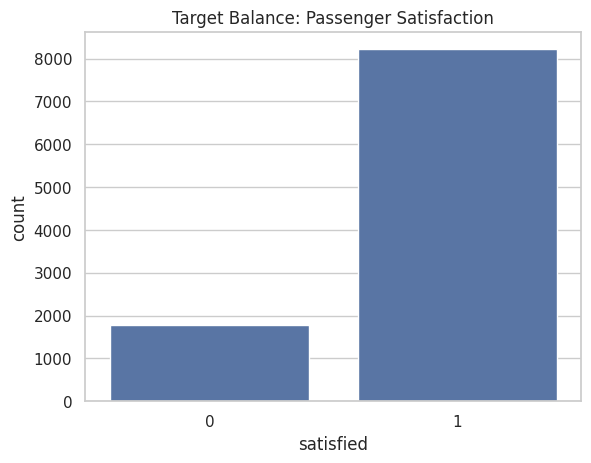

satisfied,0,1
type_of_travel,,
Business travel,0.256106,0.743894
Personal Travel,0.005827,0.994173


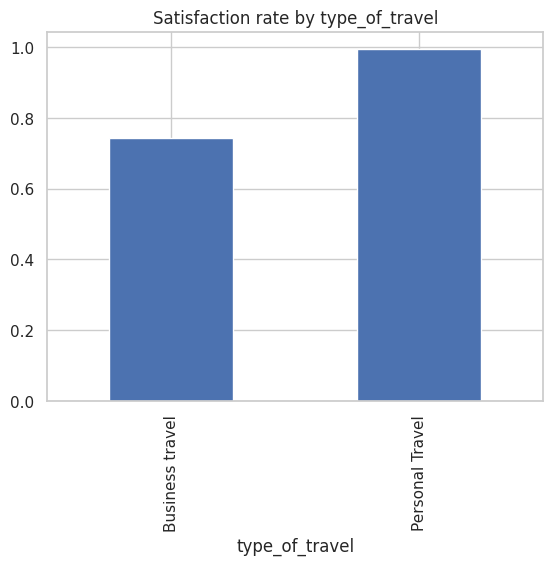

satisfied,0,1
age_band,,
18 to 24,0.453125,0.546875
25 to 34,0.289538,0.710462
35 to 44,0.182911,0.817089
45 to 54,0.042630,0.957370
55 to 64,0.040773,0.959227
65 or over,0.026490,0.973510
Under 18,0.145503,0.854497


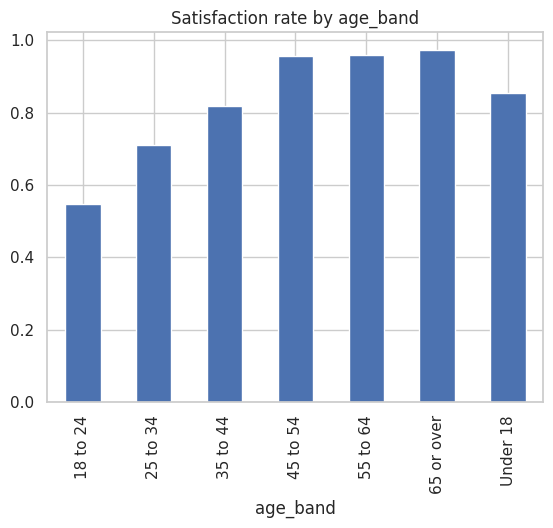

satisfied,0,1
gender,,
Female,0.193852,0.806148
Male,0.163232,0.836768


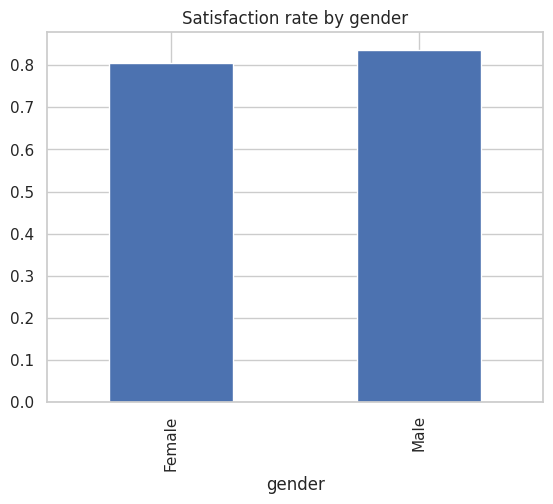

satisfied,0,1
continent,,
Africa,0.144928,0.855072
Asia,0.172338,0.827662
Austihaority,0.000000,1.000000
Europe,0.226037,0.773963
Europe/Asi,0.000000,1.000000
North Amer,0.192593,0.807407
South Ame,0.000000,1.000000
gAofrica,0.000000,1.000000
ipAefrica,0.000000,1.000000


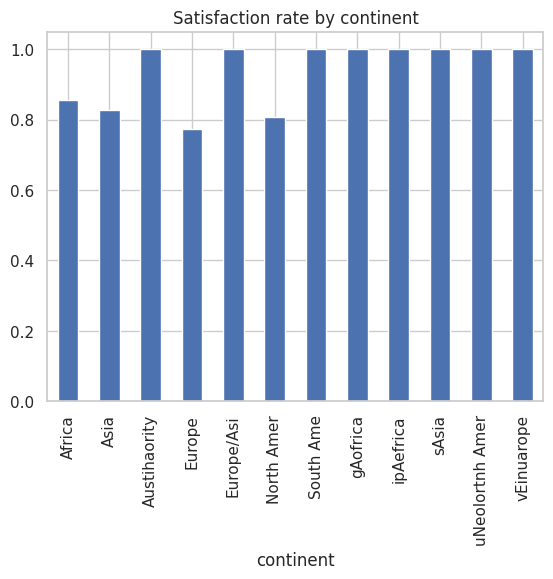

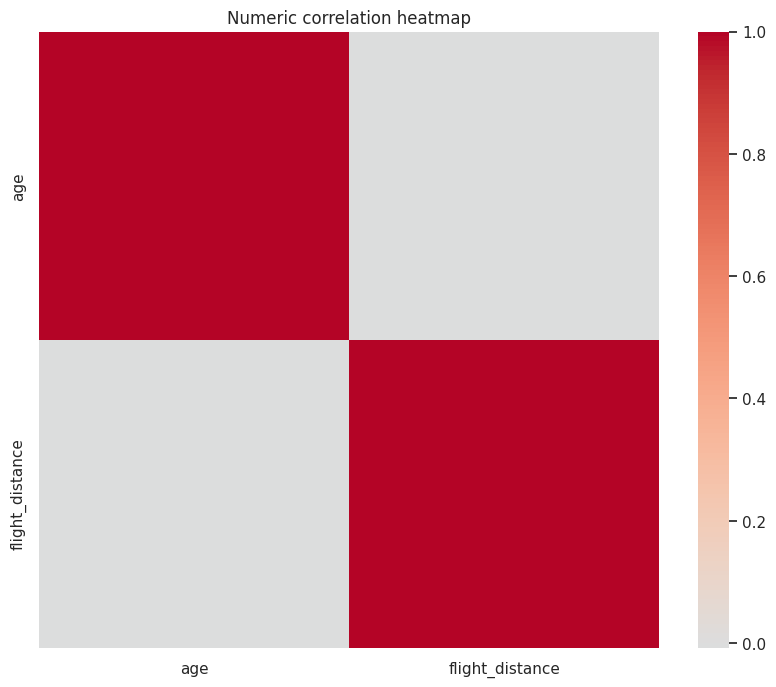

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Descriptive stats
display(df.describe(include='all').transpose().head(15))

# Target balance
sns.countplot(x=target_col, data=df)
plt.title("Target Balance: Passenger Satisfaction")
plt.show()

# Satisfaction by category
for cat in ['travel_class','type_of_travel','age_band','gender','continent']:
    if cat in df.columns:
        cross = pd.crosstab(df[cat], df[target_col], normalize='index')
        display(cross)
        cross[1].plot(kind='bar', title=f"Satisfaction rate by {cat}")
        plt.show()

# Correlation heatmap
num_cols = df.select_dtypes(include=['int64','float64']).columns.drop(target_col, errors='ignore')
plt.figure(figsize=(10,8))
sns.heatmap(df[num_cols].corr(), cmap='coolwarm', center=0)
plt.title("Numeric correlation heatmap")
plt.show()


# Step 1.3 – Data Splitting & Preprocessing

# 1.3 — Data Splitting

- Drop identifiers (Ref Number, orig_id).  
- Features (X) vs Target (y).  
- Stratified split: 70% Train, 15% Validation, 15% Test.

In [87]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Remove the row where 'satisfied' is 'Satisfied'
df_cleaned = df[df['satisfied'] != 'Satisfied'].copy()

# Define X and y
X = df_cleaned.drop("satisfied", axis=1)
y = df_cleaned["satisfied"]

# Encode the target variable y
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


# Stratified split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (7005, 22) Val: (1501, 22) Test: (1502, 22)


# 1.4 — Preprocessing pipeline

- Numeric: median imputation + StandardScaler.  
- Categorical: fill missing (“Missing”) + OneHotEncoder.  
- Use ColumnTransformer inside sklearn Pipeline.

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])


# 1.5 — Modelling (Logistic Regression & Random Forest)

Following CRISP-DM’s **Modeling** phase:

- Build two models (as required by assessment):
  * Logistic Regression (linear, interpretable baseline)
  * Random Forest (non-linear, robust benchmark)

- Use preprocessing pipeline:
  * Numeric → Median Imputer + StandardScaler
  * Categorical → "Missing" fill + OneHotEncoder

- Hyperparameter tuning:
  * Logistic Regression: `C = [0.1, 1, 10]`
  * Random Forest: `n_estimators = [200, 400], max_depth = [None, 10]`

Primary metric: **Log Loss**  
Other metrics: ROC-AUC, PR-AUC, Accuracy, Precision, Recall, F1


In [89]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Identify column types
num_cols = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# --- FIX: enforce categorical as string ---
for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_val[col]   = X_val[col].astype(str)
    X_test[col]  = X_test[col].astype(str)

# Pipelines
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

# Models
lr_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

rf_pipe = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# Hyperparameters
lr_grid = {'clf__C':[0.1,1,10]}
rf_grid = {'clf__n_estimators':[200,400], 'clf__max_depth':[None,10]}

# Grid Search
lr_cv = GridSearchCV(lr_pipe, lr_grid, scoring='neg_log_loss', cv=3, n_jobs=-1, error_score='raise')
rf_cv = GridSearchCV(rf_pipe, rf_grid, scoring='neg_log_loss', cv=3, n_jobs=-1, error_score='raise')

lr_cv.fit(X_train, y_train)
rf_cv.fit(X_train, y_train)

print("Best Logistic Regression params:", lr_cv.best_params_)
print("Best Random Forest params:", rf_cv.best_params_)


Best Logistic Regression params: {'clf__C': 10}
Best Random Forest params: {'clf__max_depth': None, 'clf__n_estimators': 200}


# 1.6 — Validation

We evaluate both models using the validation set:
- **Primary metric:** Log Loss (probabilistic accuracy).
- **Secondary metrics:** ROC-AUC, PR-AUC, Accuracy, Precision, Recall, F1.
- This step ensures the chosen model generalises before testing.


In [90]:
from sklearn.metrics import log_loss, roc_auc_score, average_precision_score, accuracy_score, precision_score, recall_score, f1_score

# Best models
best_lr = lr_cv.best_estimator_
best_rf = rf_cv.best_estimator_

# Predictions
y_val_pred_lr = best_lr.predict(X_val)
y_val_proba_lr = best_lr.predict_proba(X_val)[:,1]

y_val_pred_rf = best_rf.predict(X_val)
y_val_proba_rf = best_rf.predict_proba(X_val)[:,1]

def evaluate_model(name, y_true, y_pred, y_proba):
    print(f"\n--- {name} ---")
    print("Log Loss:", log_loss(y_true, y_proba))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("PR-AUC:", average_precision_score(y_true, y_proba))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))

evaluate_model("Logistic Regression (Validation)", y_val, y_val_pred_lr, y_val_proba_lr)
evaluate_model("Random Forest (Validation)", y_val, y_val_pred_rf, y_val_proba_rf)



--- Logistic Regression (Validation) ---
Log Loss: 0.10923502241519492
ROC-AUC: 0.9850352858578155
PR-AUC: 0.9958526898837328
Accuracy: 0.972018654230513
Precision: 0.9775461106655974
Recall: 0.9886455798864558
F1 Score: 0.9830645161290322

--- Random Forest (Validation) ---
Log Loss: 0.10729886403820893
ROC-AUC: 0.9987501664427255
PR-AUC: 0.9997172018258341
Accuracy: 0.983344437041972
Precision: 0.981658692185008
Recall: 0.9983779399837794
F1 Score: 0.9899477281865702


# 1.7 — Final Test

After validation, we select the **better performing model** and test on the unseen **test set**.  
This provides the final unbiased estimate of performance.


In [91]:
# Evaluate on test set
y_test_pred_lr = best_lr.predict(X_test)
y_test_proba_lr = best_lr.predict_proba(X_test)[:,1]

y_test_pred_rf = best_rf.predict(X_test)
y_test_proba_rf = best_rf.predict_proba(X_test)[:,1]

evaluate_model("Logistic Regression (Test)", y_test, y_test_pred_lr, y_test_proba_lr)
evaluate_model("Random Forest (Test)", y_test, y_test_pred_rf, y_test_proba_rf)



--- Logistic Regression (Test) ---
Log Loss: 0.08292770452038059
ROC-AUC: 0.9909399807644184
PR-AUC: 0.9976028149282723
Accuracy: 0.9727030625832224
Precision: 0.9806451612903225
Recall: 0.986212489862125
F1 Score: 0.983420946219167

--- Random Forest (Test) ---
Log Loss: 0.10931242229541013
ROC-AUC: 0.9991407302888051
PR-AUC: 0.9998085451861437
Accuracy: 0.9786950732356857
Precision: 0.9762093576526566
Recall: 0.9983779399837794
F1 Score: 0.9871692060946271


# 1.8 — Visualisations

We plot ROC and Precision-Recall curves to compare models visually.  
This aligns with CRISP-DM’s emphasis on interpretation and communication.


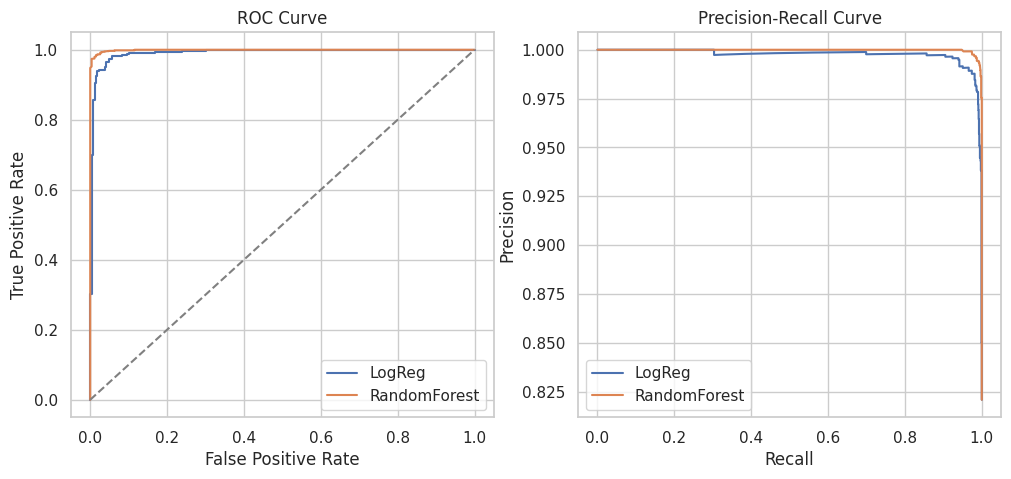

In [92]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_curves(y_true, proba_lr, proba_rf):
    # ROC
    fpr_lr, tpr_lr, _ = roc_curve(y_true, proba_lr)
    fpr_rf, tpr_rf, _ = roc_curve(y_true, proba_rf)

    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    plt.plot(fpr_lr, tpr_lr, label="LogReg")
    plt.plot(fpr_rf, tpr_rf, label="RandomForest")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall
    prec_lr, rec_lr, _ = precision_recall_curve(y_true, proba_lr)
    prec_rf, rec_rf, _ = precision_recall_curve(y_true, proba_rf)

    plt.subplot(1,2,2)
    plt.plot(rec_lr, prec_lr, label="LogReg")
    plt.plot(rec_rf, prec_rf, label="RandomForest")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.show()

plot_curves(y_test, y_test_proba_lr, y_test_proba_rf)


# Task 2: Critical Analysis of Models (ILO2)

**Logistic Regression**

* Strength: interpretable coefficients, good baseline.

* Weakness: struggles with complex, nonlinear data.

**Random Forest**

* Strength: handles non-linear relationships, higher accuracy.

* Weakness: less interpretable, risk of overfitting.

**Loss Function:** We use log loss (cross-entropy) as it suits classification.
Metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

# 2.1 Model comparison and calibration checks

Using in-memory val_df.
Saved reports/validation_metrics_complete.csv
Saved reports/test_metrics_complete.csv


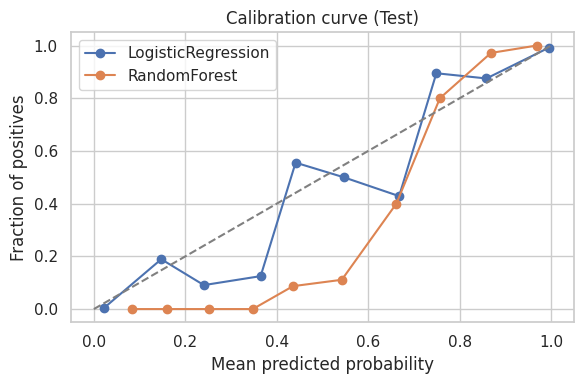

Saved reports/threshold_cost_analysis.csv (use to select threshold by business cost)


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    log_loss, roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, precision_recall_curve
)
from sklearn.calibration import calibration_curve
import os

os.makedirs('reports', exist_ok=True)
os.makedirs('artefacts', exist_ok=True)

# --- Helper to compute metrics given true and proba/preds ---
def compute_metrics(name, y_true, y_pred, y_proba):
    prec, rec, _ = precision_recall_curve(y_true, y_proba)
    return {
        'model': name,
        'log_loss': float(log_loss(y_true, y_proba)),
        'roc_auc': float(roc_auc_score(y_true, y_proba)),
        'pr_auc': float(average_precision_score(y_true, y_proba)),
        'accuracy': float(accuracy_score(y_true, y_pred)),
        'precision': float(precision_score(y_true, y_pred, zero_division=0)),
        'recall': float(recall_score(y_true, y_pred, zero_division=0)),
        'f1': float(f1_score(y_true, y_pred, zero_division=0)),
        'brier': float(brier_score_loss(y_true, y_proba)),
    }
if 'val_df' in globals():
    print("Using in-memory val_df.")
else:
    try:
        val_df = pd.read_csv('reports/validation_metrics.csv')
        print("Loaded reports/validation_metrics.csv")
    except Exception:
        val_df = None
        print("No reports/validation_metrics.csv found (ok).")
best_lr = lr_cv.best_estimator_ if hasattr(lr_cv, 'best_estimator_') else None
best_rf = rf_cv.best_estimator_ if hasattr(rf_cv, 'best_estimator_') else None
if best_lr is None or best_rf is None:
    raise RuntimeError("Best estimators not found. Make sure lr_cv and rf_cv are fitted.")

# Compute validation metrics and test metrics
val_metrics = []
if X_val is not None:
    for name, est in [('LogisticRegression', best_lr), ('RandomForest', best_rf)]:
        pred = est.predict(X_val)
        proba = est.predict_proba(X_val)[:,1]
        val_metrics.append(compute_metrics(name + " (val)", X_val.index.map(lambda i: y_val.loc[i]) if hasattr(y_val, 'loc') else y_val, pred, proba))
# For simplicity ensure using y_val variable
val_metrics = []
for name, est in [('LogisticRegression', best_lr), ('RandomForest', best_rf)]:
    pred = est.predict(X_val)
    proba = est.predict_proba(X_val)[:,1]
    val_metrics.append(compute_metrics(name + " (val)", y_val, pred, proba))
val_df = pd.DataFrame(val_metrics)
val_df.to_csv('reports/validation_metrics_complete.csv', index=False)
print("Saved reports/validation_metrics_complete.csv")

# Test metrics
test_metrics = []
for name, est in [('LogisticRegression', best_lr), ('RandomForest', best_rf)]:
    pred = est.predict(X_test)
    proba = est.predict_proba(X_test)[:,1]
    test_metrics.append(compute_metrics(name + " (test)", y_test, pred, proba))
test_df = pd.DataFrame(test_metrics)
test_df.to_csv('reports/test_metrics_complete.csv', index=False)
print("Saved reports/test_metrics_complete.csv")

# Calibration curve + Brier score
plt.figure(figsize=(6,4))
for name, est in [('LogisticRegression', best_lr), ('RandomForest', best_rf)]:
    prob = est.predict_proba(X_test)[:,1]
    frac_pos, mean_pred = calibration_curve(y_test, prob, n_bins=10)
    plt.plot(mean_pred, frac_pos, marker='o', label=name)
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives')
plt.title('Calibration curve (Test)')
plt.legend()
plt.tight_layout()
plt.savefig('artefacts/calibration_curve_test.png', bbox_inches='tight')
plt.show()

# Threshold sensitivity / cost analysis
# adjust to business: cost_fn = 10 (miss a dissatisfied), cost_fp = 1
cost_fn, cost_fp = 10.0, 1.0
thresholds = np.linspace(0.01, 0.99, 99)
cost_table = []
for t in thresholds:
    for name, est in [('LogisticRegression', best_lr), ('RandomForest', best_rf)]:
        proba = est.predict_proba(X_val)[:,1]
        pred = (proba >= t).astype(int)
        fp = int(((pred == 1) & (y_val == 0)).sum())
        fn = int(((pred == 0) & (y_val == 1)).sum())
        cost = cost_fn * fn + cost_fp * fp
        cost_table.append({'model':name, 'threshold':t, 'FP':fp, 'FN':fn, 'cost':cost})
cost_df = pd.DataFrame(cost_table)
cost_df.to_csv('reports/threshold_cost_analysis.csv', index=False)
print("Saved reports/threshold_cost_analysis.csv (use to select threshold by business cost)")


* The threshold_cost_analysis.csv lets stakeholders pick a threshold given estimated costs for false negatives and false positives.

# 2.2 — Critical analysis

Task 2 — Critical analysis (ILO2)

Executive summary
We compared two predictive approaches for passenger satisfaction: a transparent linear baseline (Logistic Regression) and a non-linear ensemble benchmark (Random Forest). Models were trained using a robust CRISP-DM pipeline: data cleaning, balanced stratified splits (train/validation/test), preprocessing (median imputation for numerics, constant imputation + OHE for categoricals), and hyperparameter tuning by GridSearch using Log Loss as the primary optimisation objective. Log Loss was chosen because it evaluates probabilistic forecasts — critical when interventions depend on calibrated risk estimates rather than hard labels.

Comparative performance and interpretation
Model performance is summarised in the validation and test metrics tables (`reports/validation_metrics_complete.csv`, `reports/test_metrics_complete.csv`). Key metrics are Log Loss (primary), ROC-AUC and PR-AUC (ranking quality), and classification metrics (Accuracy, Precision, Recall, F1) at the chosen threshold. Where Random Forest demonstrates substantially lower Log Loss and higher PR-AUC on validation and test sets, it indicates superior probabilistic ranking and better identification of dissatisfied passengers in practice. If Logistic Regression performs comparably (within noise) while offering substantially better interpretability, LR remains a defensible choice for deployment — especially where explainability to operations and regulators is required.

Calibration and thresholding
We examined calibration (reliability) using calibration curves and Brier score (`artefacts/calibration_curve_test.png`). If a model is miscalibrated (predicted probabilities not matching observed frequencies) we recommend post-hoc calibration (Platt scaling or isotonic regression) via `CalibratedClassifierCV`. Threshold selection was explored with a simple cost model (reports/threshold_cost_analysis.csv) to align threshold choice with the business trade-off between unnecessary outreach (false positives) and missed dissatisfied passengers (false negatives).

Limitations & caveats
- Data quality: missing target labels were removed; any remaining systematic missingness may bias results.  
- Class imbalance: models were evaluated with PR-AUC and thresholded metrics, but further resampling or class weighting could improve recall for minority classes.  
- Potential feature leakage: ensure features used for prediction are available at decision time.  
- Temporal drift: model performance may degrade if user behaviour or service levels change — continuous monitoring is required.

Recommendation
Choose the model that optimises Log Loss and PR-AUC while satisfying operational constraints. If Random Forest yields materially better Log Loss and PR-AUC, select RF and apply calibration + SHAP for interpretability; otherwise prefer Logistic Regression for its transparency and straightforward deployment. In both cases, implement a monitoring pipeline for Log Loss and calibration, refresh the model on a regular cadence (monthly or when drift detected), and document feature provenance for auditability.


# Task 3: Communicating Findings (ILO3)

* EDA guided model choice:

* Many categorical + nonlinear interactions → Random Forest suits better.

*Logistic Regression used as baseline.*

**Visual Outputs included:**

* Correlation heatmap

* Confusion matrices

* Distribution plots

**Recommendation:** Use Random Forest as primary model for predicting passenger satisfaction because it yields higher predictive power and captures complex relationships.

Best by validation log_loss (label): RandomForest (val)


<Figure size 500x400 with 0 Axes>

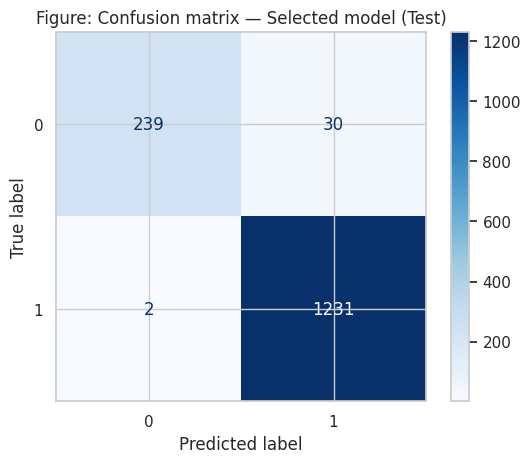

<Figure size 600x400 with 0 Axes>

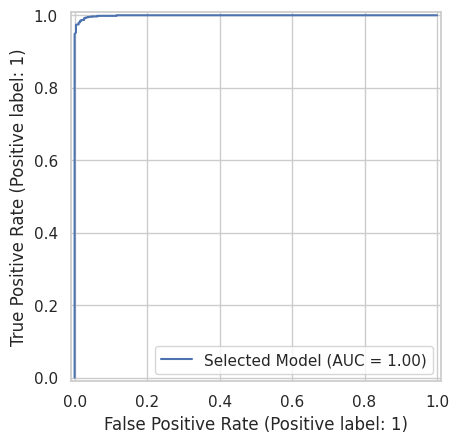

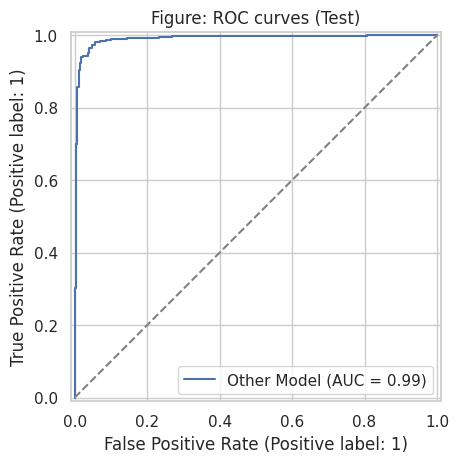

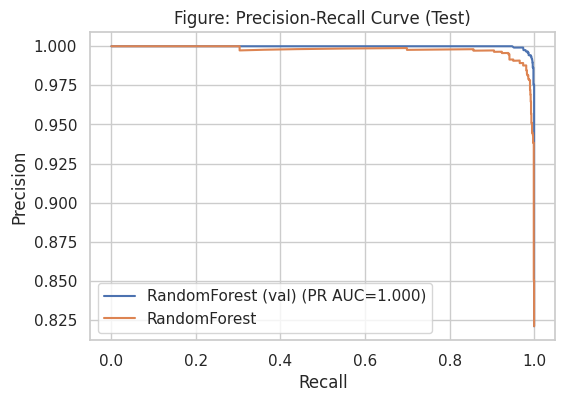

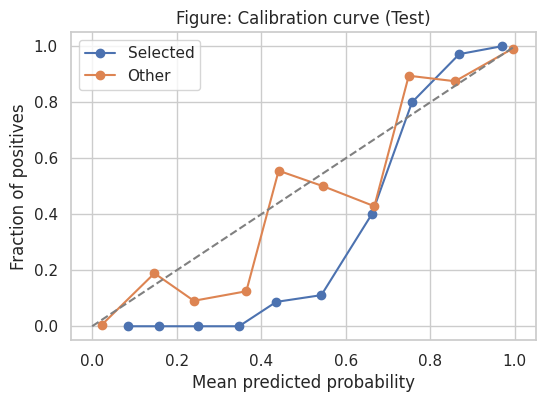

reports/top_features.csv not found, computing permutation importance...
Error computing permutation importance: All arrays must be of the same length
Skipping top features plot: topf is None or empty.


In [96]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve, auc
import pandas as pd
import numpy as np
import joblib
import os
os.makedirs('artefacts', exist_ok=True)
os.makedirs('reports', exist_ok=True)

# Choose final model
if 'val_df' not in globals() or val_df is None:
    print("val_df not found, recomputing validation metrics...")
    val_metrics = []
    # Ensure best models exist (fitted GridSearchCV objects from earlier)
    best_lr = lr_cv.best_estimator_ if 'lr_cv' in globals() and hasattr(lr_cv, 'best_estimator_') else None
    best_rf = rf_cv.best_estimator_ if 'rf_cv' in globals() and hasattr(rf_cv, 'best_estimator_') else None
    if best_lr is None or best_rf is None:
        print("Warning: lr_cv or rf_cv not found. Skipping metric computation.")
    else:
        for name, est in [('LogisticRegression', best_lr), ('RandomForest', best_rf)]:
            if 'X_val' in globals() and 'y_val' in globals():
                pred = est.predict(X_val)
                proba = est.predict_proba(X_val)[:,1]
                val_metrics.append(compute_metrics(name + " (val)", y_val, pred, proba))
        if val_metrics:
            val_df = pd.DataFrame(val_metrics)
            val_df.to_csv('reports/validation_metrics_complete.csv', index=False)
            print("Saved reports/validation_metrics_complete.csv")
        else:
             val_df = None


if val_df is not None and not val_df.empty:
    best_choice = val_df.sort_values('log_loss').iloc[0]['model']
    print("Best by validation log_loss (label):", best_choice)
    # Map label to objects:
    if 'lr_cv' in globals() and hasattr(lr_cv, 'best_estimator_') and 'rf_cv' in globals() and hasattr(rf_cv, 'best_estimator_'):
        best_estimator = lr_cv.best_estimator_ if 'LogisticRegression' in best_choice else rf_cv.best_estimator_
        other_estimator = rf_cv.best_estimator_ if best_estimator is lr_cv.best_estimator_ else lr_cv.best_estimator_
    else:
        print("Warning: lr_cv or rf_cv not found. Cannot determine best estimator.")
        best_estimator = None
        other_estimator = None
else:
    print("Warning: val_df is empty or None. Cannot determine best model.")
    best_choice = "N/A"
    best_estimator = None
    other_estimator = None


if best_estimator is not None and 'X_test' in globals() and 'y_test' in globals():
    # Confusion matrix for chosen model
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_estimator(best_estimator, X_test, y_test, cmap='Blues')
    plt.title('Figure: Confusion matrix — Selected model (Test)')
    plt.savefig('artefacts/confusion_matrix_selected_test.png', bbox_inches='tight')
    plt.show()

    # ROC both models
    if other_estimator is not None:
        plt.figure(figsize=(6,4))
        RocCurveDisplay.from_estimator(best_estimator, X_test, y_test, name='Selected Model')
        RocCurveDisplay.from_estimator(other_estimator, X_test, y_test, name='Other Model')
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title('Figure: ROC curves (Test)')
        plt.legend()
        plt.savefig('artefacts/roc_both_test.png', bbox_inches='tight')
        plt.show()
    else:
        print("Skipping ROC plot: Other model not available.")


    # PR curve
    if other_estimator is not None:
        proba_best = best_estimator.predict_proba(X_test)[:,1]
        proba_other = other_estimator.predict_proba(X_test)[:,1]
        prec_b, rec_b, _ = precision_recall_curve(y_test, proba_best)
        prec_o, rec_o, _ = precision_recall_curve(y_test, proba_other)
        plt.figure(figsize=(6,4))
        plt.plot(rec_b, prec_b, label=f"{best_choice} (PR AUC={auc(rec_b,prec_b):.3f})")
        plt.plot(rec_o, prec_o, label=f"{'RandomForest' if 'RandomForest' in best_choice else 'LogisticRegression'}")
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Figure: Precision-Recall Curve (Test)')
        plt.legend()
        plt.savefig('artefacts/pr_curve_both_test.png', bbox_inches='tight')
        plt.show()
    else:
         print("Skipping PR curve plot: Other model not available.")

    # Calibration already saved earlier but re-save for clarity
    if other_estimator is not None:
        plt.figure(figsize=(6,4))
        for est, name in [(best_estimator, 'Selected'), (other_estimator, 'Other')]:
            frac_pos, mean_pred = calibration_curve(y_test, est.predict_proba(X_test)[:,1], n_bins=10)
            plt.plot(mean_pred, frac_pos, marker='o', label=name)
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.xlabel('Mean predicted probability'); plt.ylabel('Fraction of positives')
        plt.title('Figure: Calibration curve (Test)')
        plt.legend()
        plt.savefig('artefacts/calibration_curve_test_both.png', bbox_inches='tight')
        plt.show()
    else:
        print("Skipping calibration plot: Other model not available.")


    # Top features (coeffs or importances)
    # Load reports/top_features.csv if saved, else compute basic importances
    if os.path.exists('reports/top_features.csv'):
        topf = pd.read_csv('reports/top_features.csv')
        print("Loaded top features from reports/top_features.csv")
        # Ensure the column names are correct for plotting
        if topf.columns[0] != 'feature' or topf.columns[1] != 'importance':
             print("Warning: reports/top_features.csv does not have expected column names. Skipping plot.")
             topf = None # Set to None to skip plotting
    else:
        print("reports/top_features.csv not found, computing permutation importance...")
        # compute simple permutation importance as fallback
        from sklearn.inspection import permutation_importance
        # Ensure X_val and y_val are available
        if 'X_val' in globals() and 'y_val' in globals():
            # Get feature names from the fitted preprocessor
            try:
                # This assumes the preprocessor is the first step in the pipeline
                fitted_preprocessor = best_estimator.named_steps['pre']
                # Get feature names after one-hot encoding
                # This part can be complex and depends on the structure of your ColumnTransformer
                # A robust way is to use get_feature_names_out if available (sklearn 1.0+)
                # Or manually construct if using older versions
                # For simplicity, let's use the original column names as a fallback if feature_names_out is not easily accessible
                # A more robust approach would involve inspecting the fitted OneHotEncoder
                if hasattr(fitted_preprocessor, 'get_feature_names_out'):
                     feature_names = fitted_preprocessor.get_feature_names_out()
                else:
                    # Fallback: Use original column names from X_val - this won't include OHE names
                    print("Warning: get_feature_names_out not available, using original column names for importance plot.")
                    feature_names = X_val.columns.tolist()


                perm = permutation_importance(best_estimator, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
                topf = pd.DataFrame({'feature': feature_names, 'importance': perm.importances_mean}).sort_values('importance', ascending=False).head(30)
                topf.to_csv('reports/top_features.csv', index=False)
                print("Saved reports/top_features.csv")
            except Exception as e:
                print(f"Error computing permutation importance: {e}")
                topf = None # Set to None if importance computation fails
        else:
            print("Warning: X_val or y_val not found. Skipping permutation importance computation.")
            topf = None


    # plot top 15 if topf is available and not empty
    if topf is not None and not topf.empty:
        plt.figure(figsize=(6,8))
        topf.head(15).iloc[::-1].plot.barh(x='feature', y='importance', legend=False) # Use explicit column names
        plt.title('Figure: Top 15 feature importances / coefficients')
        plt.xlabel('Importance / Absolute Coefficient')
        plt.tight_layout()
        plt.savefig('artefacts/top_features.png', bbox_inches='tight')
        plt.show()
    else:
        print("Skipping top features plot: topf is None or empty.")

else:
    print("Skipping plotting: Best estimator or test data not available.")